# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from thermolib.thermodynamics.fep import BaseFreeEnergyProfile, plot_feps
from thermolib.thermodynamics.histogram import Histogram1D,plot_histograms
from thermolib.tools import read_wham_input, blav

import numpy as np, matplotlib.pyplot as pp

from molmod.units import *

# WHAM with error estimation

## Comparison with external WHAM script

### Define parabolic bias potentials and read corresponding trajectories

In [ ]:
#read temperature and bias potentials from wham_input.txt file
fn = '/home/louis/hpc/data/shared/massimo/for_Louis/wham_input.txt'
temp, biasses, trajectories = read_wham_input(fn, path_template_colvar_fns='colvar_%s.dat', kappa_unit='kjmol', q0_unit='au', stride=10, verbose=True)

### Do WHAM

In [ ]:
bins = np.arange(-1.2, 1.42, 0.02)
hist_p = Histogram1D.from_wham(bins, trajectories, biasses, temp, error_estimate='mle_p', Nscf=1000, convergence=1e-6, verbose=False)
hist_f = Histogram1D.from_wham(bins, trajectories, biasses, temp, error_estimate='mle_f', Nscf=1000, convergence=1e-6, verbose=False)

### Construct and plot free energy profile

In [ ]:
fep_p = BaseFreeEnergyProfile.from_histogram(hist_p, temp=temp)
fep_p.set_ref(ref='min')
fep_f = BaseFreeEnergyProfile.from_histogram(hist_f, temp=temp)
fep_f.set_ref(ref='min')

Compare with free energy profile generated by external wham script

In [ ]:
fep_ext = BaseFreeEnergyProfile.from_txt('/home/louis/hpc/data/shared/massimo/for_Louis/fes.dat', temp, cvcol=0, fcol=1, cv_unit='au', f_unit='kjmol')
fep_ext.set_ref(ref='min')
#fep_ext.plot('fep_US_external.png')

In [ ]:
plot_feps('fep_US_compare_error.png', [fep_p,fep_f,fep_ext], labels=['ThermoLIB (mle-p)', 'ThermoLIB (mle-f)', 'WHAMscript'], colors=[None,None,'0.3'], temp=temp, flims=[0.0, 140])

## Comparison single histogram method for 'unbiases' simulation

In this section, we will apply the WHAM reconstruction to a single unbiased simulation and compare the free energy profile and its error with the direct construction of the single histogram implemented in ThermoLIB. To apply the WHAM reconstructio to a single simulation, we are going to split the simulation into 10 subsequent trajectories and apply WHAM with zero-values biasses.

However, for the input data we will use the simulation trajectory of a single umbrella from the umbrella simulation above. Even though this simulation was biases, it doesn't matter for the purpose at hand, i.e. we will suppose it is not biased at all but represents the equilibrium simulation of some system.

In [ ]:
fn_single = '/home/louis/hpc/data/shared/massimo/for_Louis/colvar_U8.dat'
traj_single = np.loadtxt(fn_single)[:,1]
bins = np.arange(0.4, 1.11, 0.01)
temp = 573*kelvin

### Direct histogram construction

In [ ]:
hist_single = Histogram1D.from_single_trajectory(traj_single, bins, error_estimate='mle_f')
fep_single = BaseFreeEnergyProfile.from_histogram(hist_single, temp=temp)
fep_single.set_ref(ref='min')
#fep_single.plot('fep_single_direct.png', flim=35*kjmol)

### WHAM 'reconstruction'

Generate 'trajectories' and 'biases' of pseudo umbrellas

In [ ]:
nblocks = 5
trajectories = [None,]*nblocks
biasses = [None,]*nblocks
len_block = len(traj_single)//nblocks
for iblock in range(nblocks):
    block = traj_single[iblock*len_block:(iblock+1)*len_block]
    trajectories[iblock] = block
    biasses[iblock] = lambda q: np.zeros(len(q))

In [ ]:
hist_wham = Histogram1D.from_wham(bins, trajectories, biasses, temp, error_estimate='mle_f', Nscf=1000, convergence=1e-6)

In [ ]:
fep_wham = BaseFreeEnergyProfile.from_histogram(hist_wham, temp=temp)
fep_wham.set_ref(ref='min')
#fep_wham.plot('fep_single_wham.png', flim=35*kjmol)

In [ ]:
plot_feps('fep_single_compare_error.png', [fep_wham,fep_single], labels=['WHAM','single'], flims=[0,35])

## Impact correlation on WHAM reconstuction

In [ ]:
fn = '/home/louis/hpc/data/shared/massimo/for_Louis/wham_input.txt'
bins = np.arange(-1.2, 1.42, 0.02)

In [ ]:
temp, biasses, trajectories_1 = read_wham_input(fn, path_template_colvar_fns='colvar_%s.dat', kappa_unit='kjmol', q0_unit='au', stride=1)
hist_1 = Histogram1D.from_wham(bins, trajectories_1, biasses, temp, error_estimate='mle_f', Nscf=1000, convergence=1e-6)
fep_1 = BaseFreeEnergyProfile.from_histogram(hist_1, temp=temp)
fep_1.set_ref(ref='min')

In [ ]:
temp, biasses, trajectories_100 = read_wham_input(fn, path_template_colvar_fns='colvar_%s.dat', kappa_unit='kjmol', q0_unit='au', stride=100)
hist_100 = Histogram1D.from_wham(bins, trajectories_100, biasses, temp, error_estimate='mle_p', Nscf=1000, convergence=1e-6)
fep_100 = BaseFreeEnergyProfile.from_histogram(hist_100, temp=temp)
fep_100.set_ref(ref='min')

In [ ]:
plot_feps('fep_US_correlation.png', [fep_100,fep_1], labels=['stride=100', 'stride=1'], flims=[0,140])

Below we try to estimate the correlation time from block averaging of the collective variable itself during the trajectories

In [ ]:
mean, error, corrtime = blav(trajectories[1][::1], blocksizes=np.arange(1,5000,1), fn_plot='trajectory_U2blav.png', plot_ac=True, ac_range=np.arange(0,5000,1), acft_plot_range=[0,0.1])
print('Correlation time = %.3f timesteps' %corrtime)

We now compute the WHAM profile 10 times, each time with trajectories at 1 in 100 sub sampling but shifted over 10 steps with respect to each other

In [3]:
fn = '/home/louis/hpc/data/shared/massimo/for_Louis/wham_input.txt'
bins = np.arange(-1.2, 1.42, 0.02)

In [4]:
histograms = []
for start in np.arange(0,100,10):
    print("Constructing WHAM FEP for start=%i" %start)
    temp, biasses, trajectories = read_wham_input(fn, path_template_colvar_fns='colvar_%s.dat', kappa_unit='kjmol', q0_unit='au', start=start, stride=100)
    hist = Histogram1D.from_wham(bins, trajectories, biasses, temp)
    histograms.append(hist)
hist = Histogram1D.from_average(histograms, error_estimate='std')

Constructing WHAM FEP for start=0
WHAM SCF Converged!
Constructing WHAM FEP for start=10
WHAM SCF Converged!
Constructing WHAM FEP for start=20
WHAM SCF Converged!
Constructing WHAM FEP for start=30
WHAM SCF Converged!
Constructing WHAM FEP for start=40
WHAM SCF Converged!
Constructing WHAM FEP for start=50
WHAM SCF Converged!
Constructing WHAM FEP for start=60
WHAM SCF Converged!
Constructing WHAM FEP for start=70
WHAM SCF Converged!
Constructing WHAM FEP for start=80
WHAM SCF Converged!
Constructing WHAM FEP for start=90
WHAM SCF Converged!


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


<Figure size 432x288 with 0 Axes>

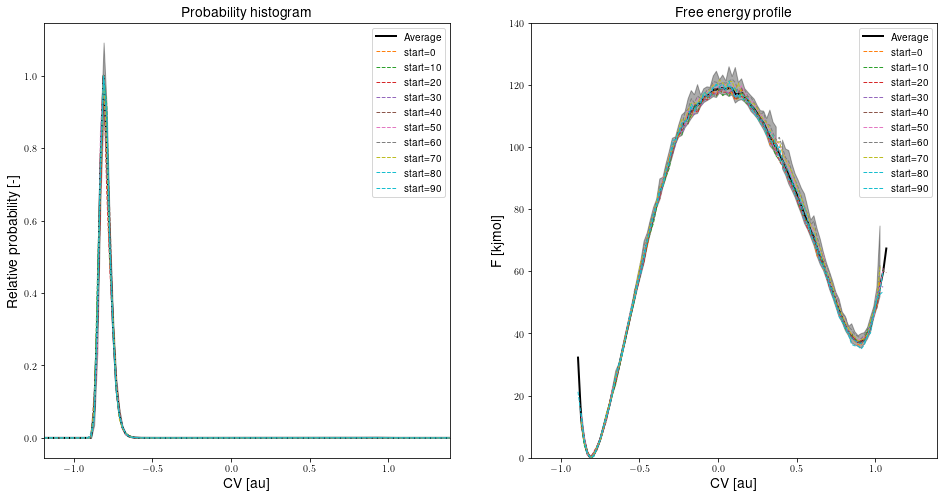

In [5]:
plot_histograms('histograms_US_correlation_2.png', [hist]+histograms, labels=['Average']+['start=%i' %i for i in np.arange(0,100,10)], temp=temp, flims=[0,140],
               colors    =['k']+[None,]*10,
               linewidths=[2  ]+[1   ,]*10,
               linestyles=['-']+['--',]*10)

We now devide the original data in 5 subsequent blocks and compute the WHAM FEP for each block

In [6]:
nblocks = 5
blocksize = 10000
histograms = []
labels = []
for iblock in range(nblocks):
    start, end = iblock*blocksize, (iblock+1)*blocksize
    print("Constructing histogram for block [%i,%i]" %(start,end))
    temp, biasses, trajectories = read_wham_input(fn, path_template_colvar_fns='colvar_%s.dat', kappa_unit='kjmol', q0_unit='au', start=start, end=end, stride=1)
    hist = Histogram1D.from_wham(bins, trajectories, biasses, temp)
    histograms.append(hist)
    labels.append("Block[%i,%i]"%(start,end))
hist_blockavg = Histogram1D.from_average(histograms, error_estimate='std', nsigma=2)

Constructing histogram for block [0,10000]
WHAM SCF Converged!
Constructing histogram for block [10000,20000]
WHAM SCF Converged!
Constructing histogram for block [20000,30000]
WHAM SCF Converged!
Constructing histogram for block [30000,40000]
WHAM SCF Converged!
Constructing histogram for block [40000,50000]
WHAM SCF Converged!


<Figure size 432x288 with 0 Axes>

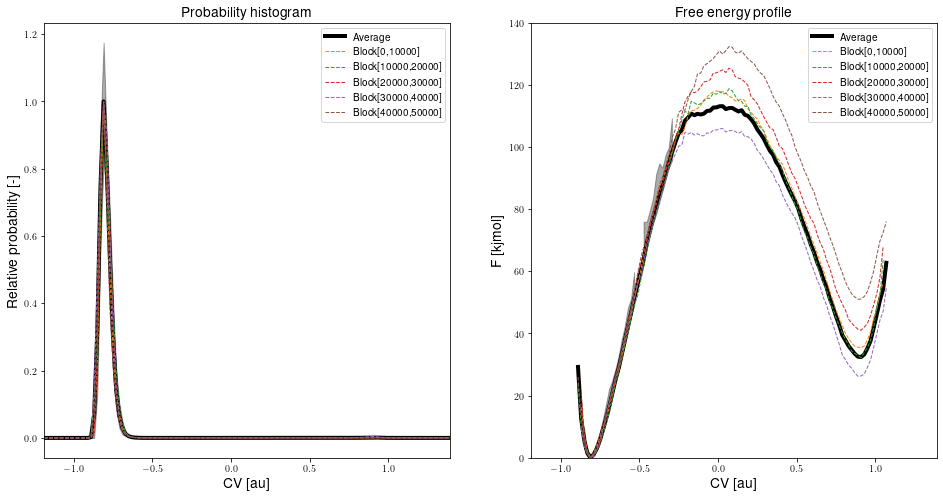

In [7]:
plot_histograms('histogram_US_correaltion_3.png', [hist_blockavg]+histograms, labels=['Average']+labels, temp=temp, flims=[0,140], 
                colors    =['k']+[None,]*nblocks, 
                linestyles=['-']+['--',]*nblocks, 
                linewidths=[4  ]+[1   ,]*nblocks)

## Bootstrapping

In [22]:
feps = []
Nboot = 10
histograms = []
temp, biasses, trajectories = read_wham_input(fn, path_template_colvar_fns='colvar_%s.dat', kappa_unit='kjmol', q0_unit='au')
for iboot in range(Nboot):
    new_trajectories = []
    for traj in trajectories:
        Nsteps = len(traj)
        indices = np.random.randint(0, high=Nsteps, size=Nsteps)
        new_trajectories.append(traj[indices]) 
    histogram = Histogram1D.from_wham(bins, new_trajectories, biasses, temp, error_estimate='mle_f')
    histograms.append(histogram.copy())
    feps.append(BaseFreeEnergyProfile.from_histogram(histogram,temp))
hist = Histogram1D.from_average(histograms, error_estimate='std')

WHAM SCF Converged!
WHAM SCF Converged!
WHAM SCF Converged!
WHAM SCF Converged!
WHAM SCF Converged!
WHAM SCF Converged!
WHAM SCF Converged!
WHAM SCF Converged!
WHAM SCF Converged!
WHAM SCF Converged!


<Figure size 432x288 with 0 Axes>

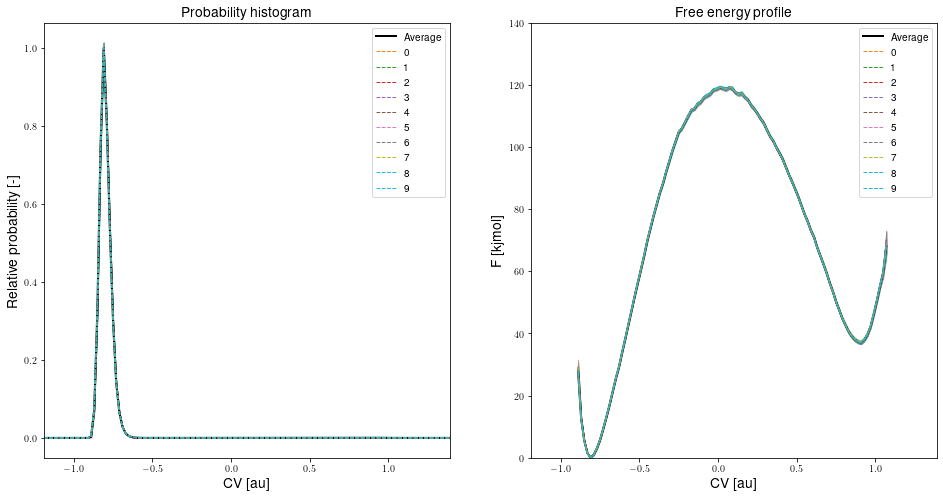

In [23]:
plot_histograms('histograms_US_bootstrapping.png', [hist]+histograms, labels=['Average']+['%i' %i for i in np.arange(0,10,1)], temp=temp, flims=[0,140],
               colors    =['k']+[None,]*10,
               linewidths=[2  ]+[1   ,]*10,
               linestyles=['-']+['--',]*10)